In [14]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
file_path = r'C:\Users\Gregory Bazuaye\Downloads\graph_opt (4).pb'
net = cv.dnn.readNetFromTensorflow(file_path)

In [23]:
inWidth = 368
inHeight = 368
thr = 0.2

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]


In [19]:
im_path = r'C:\Users\Gregory Bazuaye\Downloads\pose.jpg'
img = mpimg.imread(im_path)

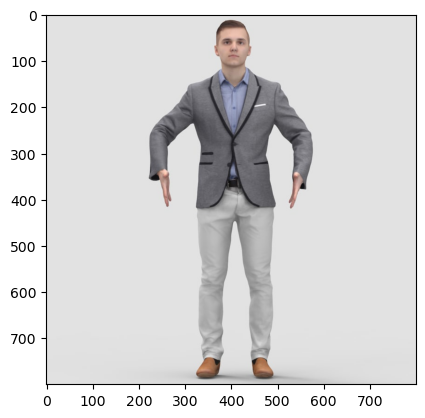

In [20]:
plt.imshow(img)

In [30]:
def pose_estimation (frame) :
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    
    output  = net.forward()
    output = output[: , :19 , : , :]
    
    assert(len(BODY_PARTS) == output.shape[1])
    
    points = []
    
    
    for i in range (len(BODY_PARTS)) :
        heat_map = output[0 , i , : , :]
        _, conf , _ , point = cv.minMaxLoc(heat_map)
        x = frame_width * point[0] / output.shape[3]
        y = frame_height *point[1] / output.shape[2]
        
        points.append((int(x) , int(y)) if conf > thr else None)
        
    for pair in POSE_PAIRS :
        part_from = pair[0]
        part_to = pair[0]
        
        assert(part_from in BODY_PARTS)
        assert(part_to in BODY_PARTS)
        
        id_from = BODY_PARTS[part_from]
        id_to = BODY_PARTS[part_to]
        
        if points[id_from ] and points[id_to] :
            cv.line(frame, points[id_from], points[id_to], (0, 255, 0), 3)
            cv.ellipse(frame, points[id_from], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[id_to], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame 


In [31]:
est_img = pose_estimation(img)

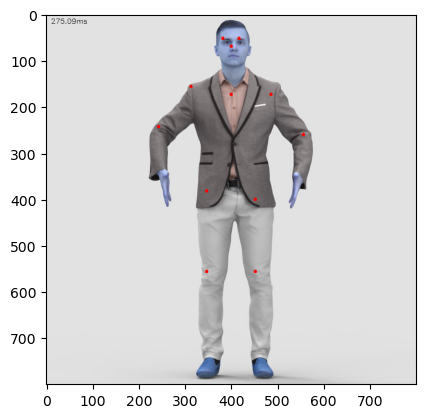

In [37]:
plt.imshow(cv.cvtColor(est_img , cv.COLOR_BGR2RGB))
#plt.imshow(est_img)

In [ ]:
cap = cv.VideoCapture(1)
cap.set(cv.CAP_PROP_FPS , 10)
cap.set(3 , 800)
cap.set(4 , 800)


if not cap.isOpened():
    cap = cv.VideoCapture(0)
if  not cap.isOpened():
    raise IOError('Cannot Open Webcam')

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose using OpenCV', frame)
    